# Import the essential libraries

In [1]:
# Essential and common packages
import os
import glob

# Plots and bars
import matplotlib.pyplot as plt

# Computation library
import numpy as np

# Tensorflow for building the resnet50 model
import tensorflow.python.keras as k
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.initializers import random_uniform, glorot_uniform
from keras.models import Model

# Sklearn for confusion matrix
import itertools
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

# For visualization of plots without plt.show()
%matplotlib inline

In [2]:
tf.__version__

'2.14.0'

# Define the required variable

In [3]:
dataset_url = 'C:/ocean/dataset'
batch_size = 32
img_height = 64
img_width = 64
validation_split=0.2
rescale=1.0/255

# Data preparation for the model

In [4]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(validation_split=validation_split, rescale=rescale)
dataset = tf.keras.preprocessing.image_dataset_from_directory(dataset_url, image_size=(img_height, img_width), batch_size=batch_size)

Found 8382 files belonging to 3 classes.


In [5]:
train_dataset = datagen.flow_from_directory(batch_size=batch_size,
                                           directory=dataset_url,
                                           shuffle=True,
                                           target_size=(img_height, img_width),
                                           subset="training",
                                           class_mode='categorical')

Found 6707 images belonging to 3 classes.


In [6]:
test_dataset = datagen.flow_from_directory(batch_size=batch_size,
                                           directory=dataset_url,
                                           shuffle=True,
                                           target_size=(img_height, img_width),
                                           subset="validation",
                                           class_mode='categorical')

Found 1675 images belonging to 3 classes.


# Visualization of input datasets

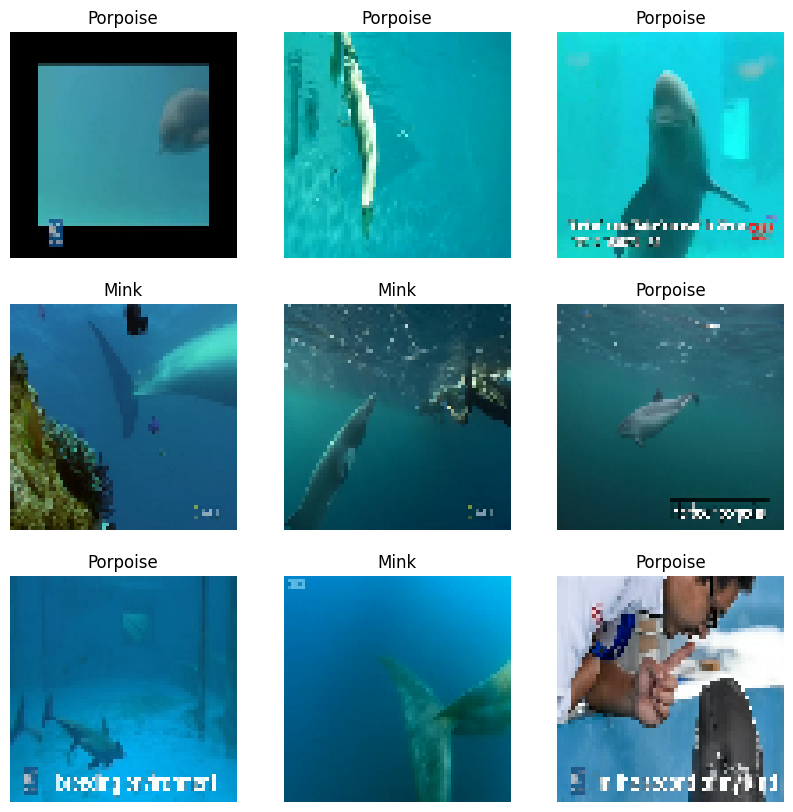

In [7]:
class_names = dataset.class_names
plt.figure(figsize=(10, 10))
for images, labels in dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

# ResNet50 Model building

##### ResNet50 Architecture
![resnet50](https://raw.githubusercontent.com/iamtekson/deep-learning-for-earth-observation/main/Notebooks/01.%20image-classification/img/resnet50.png)

###### ResNet Identity block
![identity block](https://raw.githubusercontent.com/iamtekson/deep-learning-for-earth-observation/main/Notebooks/01.%20image-classification/img/convblock.png)

###### ResNet Convolution Block
![conv block](https://raw.githubusercontent.com/iamtekson/deep-learning-for-earth-observation/main/Notebooks/01.%20image-classification/img/convblock.png)



In [8]:
def identity_block(X, f, filters, training=True, initializer=random_uniform):
    """
    Implementation of the identity block
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    training -- True: Behave in training mode
                False: Behave in inference mode
    initializer -- to set up the initial weights of a layer. Equals to random uniform initializer
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value.
    X_shortcut = X
    cache = []
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = 1, strides = (1, 1), padding = 'valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training) # Default axis
    X = Activation('relu')(X)
    
    # Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1, 1), padding = 'same', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1, 1), padding = 'valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X_shortcut, X])
    X = X = Activation('relu')(X, training = training)

    return X

In [9]:
def convolutional_block(X, f, filters, s = 2, training=True, initializer=glorot_uniform):
    """
    Implementation of the convolutional block
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    s -- Integer, specifying the stride to be used
    training -- True: Behave in training mode
                False: Behave in inference mode
    initializer -- to set up the initial weights of a layer. Equals to Glorot uniform initializer, 
                   also called Xavier uniform initializer.
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    
    # First component of main path glorot_uniform(seed=0)
    X = Conv2D(filters = F1, kernel_size = 1, strides = (s, s), padding='valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training=training)
    X = Activation('relu')(X)

    
    # Second component of main path (≈3 lines)
    X = Conv2D(F2, (f, f), strides = (1, 1), padding = 'same', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(F3, (1, 1), strides = (1, 1), padding = 'valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training)

    ##### SHORTCUT PATH #### (≈2 lines)
    X_shortcut = Conv2D(F3, (1, 1), strides = (s, s), padding = 'valid', kernel_initializer = initializer(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3)(X_shortcut, training = training)

    # Final step: Add shortcut value to main path (Use this order [X, X_shortcut]), and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

In [10]:
def ResNet50(input_shape = (64, 64, 3), classes = 6):
    """
    Stage-wise implementation of the architecture of the popular ResNet50:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> FLATTEN -> DENSE 

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    
    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], s = 1)
    X = identity_block(X, 3, [64, 64, 256])
    X = identity_block(X, 3, [64, 64, 256])
    
   # Stage 3 (≈4 lines)
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], s = 2)
    X = identity_block(X, 3, [128, 128, 512])
    X = identity_block(X, 3, [128, 128, 512])
    X = identity_block(X, 3, [128, 128, 512])

    # Stage 4 (≈6 lines)
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], s = 2)
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])

    # Stage 5 (≈3 lines)
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], s = 2)
    X = identity_block(X, 3, [512, 512, 2048])
    X = identity_block(X, 3, [512, 512, 2048])

    # AVGPOOL (≈1 line). Use "X = AveragePooling2D(...)(X)"
    X = AveragePooling2D(pool_size = (2, 2), name = 'avg_pool')(X)
    

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', kernel_initializer = glorot_uniform(seed=0))(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X)

    return model

# Model train

In [11]:
model = ResNet50(input_shape=(64,64,3), classes=3)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 70, 70, 3)            0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv2d (Conv2D)             (None, 32, 32, 64)           9472      ['zero_padding2d[0][0]']      
                                                                                                  
 batch_normalization (Batch  (None, 32, 32, 64)           256       ['conv2d[0][0]']          

In [12]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
# please increase the epoch for higher accuracy (epochs=100)
history = model.fit(train_dataset, validation_data=test_dataset, epochs=5, batch_size=32)

Epoch 1/5


InvalidArgumentError: Graph execution error:

Detected at node categorical_crossentropy/softmax_cross_entropy_with_logits defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\9818m\AppData\Roaming\Python\Python311\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\9818m\AppData\Roaming\Python\Python311\site-packages\traitlets\config\application.py", line 1053, in launch_instance

  File "C:\Users\9818m\AppData\Roaming\Python\Python311\site-packages\ipykernel\kernelapp.py", line 737, in start

  File "C:\Users\9818m\AppData\Roaming\Python\Python311\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "c:\Users\9818m\AppData\Local\Programs\Python\Python311\Lib\asyncio\base_events.py", line 607, in run_forever

  File "c:\Users\9818m\AppData\Local\Programs\Python\Python311\Lib\asyncio\base_events.py", line 1922, in _run_once

  File "c:\Users\9818m\AppData\Local\Programs\Python\Python311\Lib\asyncio\events.py", line 80, in _run

  File "C:\Users\9818m\AppData\Roaming\Python\Python311\site-packages\ipykernel\kernelbase.py", line 524, in dispatch_queue

  File "C:\Users\9818m\AppData\Roaming\Python\Python311\site-packages\ipykernel\kernelbase.py", line 513, in process_one

  File "C:\Users\9818m\AppData\Roaming\Python\Python311\site-packages\ipykernel\kernelbase.py", line 418, in dispatch_shell

  File "C:\Users\9818m\AppData\Roaming\Python\Python311\site-packages\ipykernel\kernelbase.py", line 758, in execute_request

  File "C:\Users\9818m\AppData\Roaming\Python\Python311\site-packages\ipykernel\ipkernel.py", line 426, in do_execute

  File "C:\Users\9818m\AppData\Roaming\Python\Python311\site-packages\ipykernel\zmqshell.py", line 549, in run_cell

  File "C:\Users\9818m\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py", line 3024, in run_cell

  File "C:\Users\9818m\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py", line 3079, in _run_cell

  File "C:\Users\9818m\AppData\Roaming\Python\Python311\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner

  File "C:\Users\9818m\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py", line 3284, in run_cell_async

  File "C:\Users\9818m\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py", line 3466, in run_ast_nodes

  File "C:\Users\9818m\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py", line 3526, in run_code

  File "C:\Users\9818m\AppData\Local\Temp\ipykernel_6736\2522362808.py", line 2, in <module>

  File "c:\Users\9818m\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "c:\Users\9818m\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 1783, in fit

  File "c:\Users\9818m\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 1377, in train_function

  File "c:\Users\9818m\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 1360, in step_function

  File "c:\Users\9818m\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 1349, in run_step

  File "c:\Users\9818m\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 1127, in train_step

  File "c:\Users\9818m\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 1185, in compute_loss

  File "c:\Users\9818m\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\compile_utils.py", line 277, in __call__

  File "c:\Users\9818m\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\losses.py", line 143, in __call__

  File "c:\Users\9818m\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\losses.py", line 270, in call

  File "c:\Users\9818m\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\losses.py", line 2221, in categorical_crossentropy

  File "c:\Users\9818m\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\backend.py", line 5581, in categorical_crossentropy

logits and labels must be broadcastable: logits_size=[32,10] labels_size=[32,3]
	 [[{{node categorical_crossentropy/softmax_cross_entropy_with_logits}}]] [Op:__inference_train_function_26435]

In [ ]:
model.save(r'model/model_05_epoch.h5')

# Load model

In [ ]:
from keras.models import load_model
model = load_model(r"model/model_05_epoch.h5")

# analyzing results and visualization

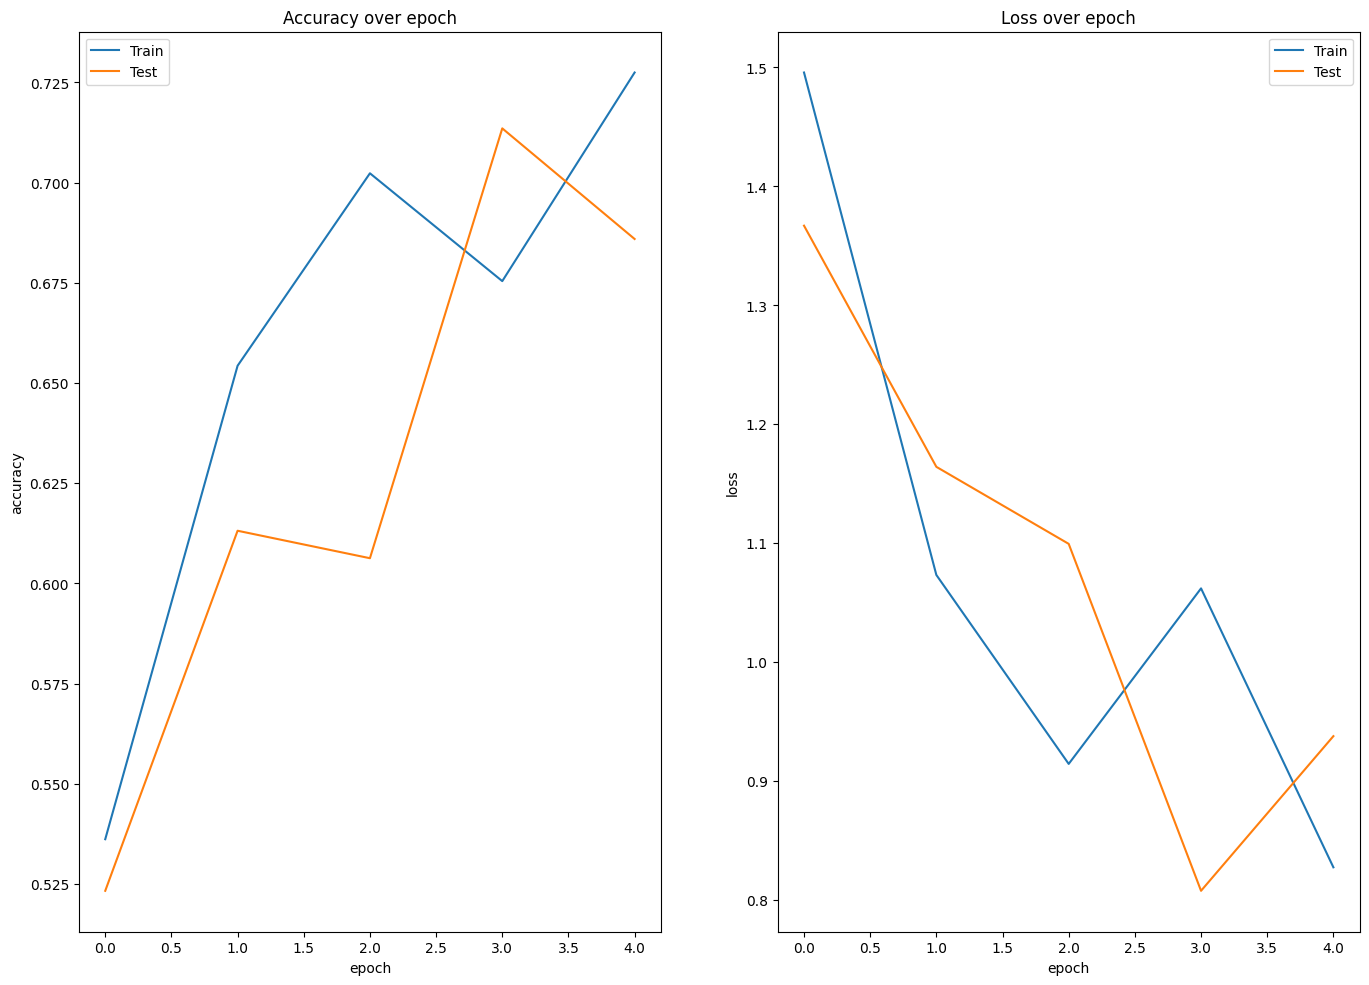

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16.53, 11.69))
ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_xlabel('epoch')
ax1.set_ylabel('accuracy')
ax1.set_title('Accuracy over epoch')
ax1.legend(['Train', 'Test'], loc='upper left')

ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_xlabel('epoch')
ax2.set_ylabel('loss')
ax2.set_title('Loss over epoch')
ax2.legend(['Train', 'Test'], loc="upper right")

# Confusion matrix

In [ ]:
y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for i, (image_batch, label_batch) in enumerate(test_dataset):   # use dataset.unbatch() with repeat
    # append true labels
    y_true.append(label_batch)
    # compute predictions
    preds = model.predict(image_batch)
    # append predicted labels
    y_pred.append(np.argmax(preds, axis =  1))
    if i==300:
        break

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
correct_labels = np.argmax(correct_labels, axis=1)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 23ms/step


In [ ]:
cm = confusion_matrix(correct_labels, predicted_labels)
cm

array([[842,  10,  55,  11,   3,  22,  62,   0,  29,  29],
       [  0, 846,  12,   0,   0,   8,   0,   1,   1, 200],
       [ 31,  28, 567,  35,  15,  10, 292,  50,  19,  22],
       [ 72,  14,  25, 493,  48,  21, 100,  26, 104,   4],
       [ 52,   0,   3,  41, 748,   0,  14,  21,  11,   0],
       [ 30, 123,  32,   8,   0, 307,  51,   2,  59,  82],
       [228,   9,  62,  27,  15,  15, 497,   8,  25,   5],
       [  9,   1,  64,  58,  65,   0, 135, 718,  15,   2],
       [ 58,  40,  36, 135,  12,  43,  11,   5, 541,  16],
       [ 18,  39,  54,   2,   2,   7,   1,   4,   7, 944]], dtype=int64)

In [ ]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        figsize=(10, 10),
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar(shrink = 0.7)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[842  10  55  11   3  22  62   0  29  29]
 [  0 846  12   0   0   8   0   1   1 200]
 [ 31  28 567  35  15  10 292  50  19  22]
 [ 72  14  25 493  48  21 100  26 104   4]
 [ 52   0   3  41 748   0  14  21  11   0]
 [ 30 123  32   8   0 307  51   2  59  82]
 [228   9  62  27  15  15 497   8  25   5]
 [  9   1  64  58  65   0 135 718  15   2]
 [ 58  40  36 135  12  43  11   5 541  16]
 [ 18  39  54   2   2   7   1   4   7 944]]


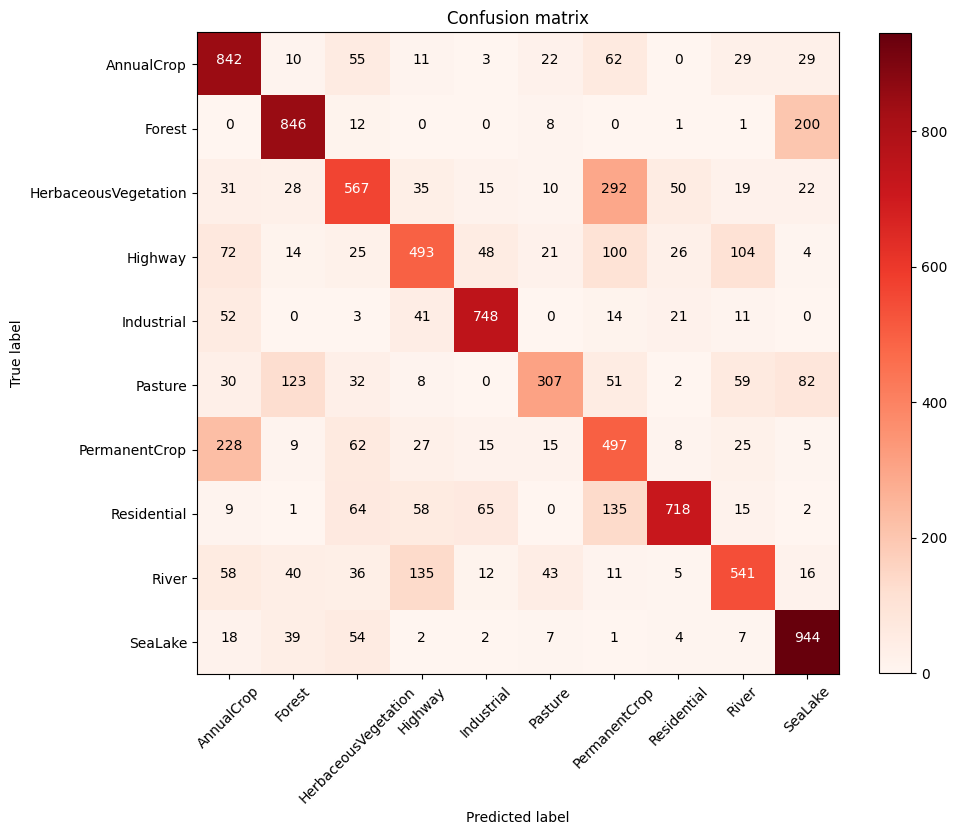

In [ ]:
plot_confusion_matrix(cm, train_dataset.class_indices, cmap='Reds')

# Thank you 